# Supplementary Regression Primer
## Markov Switching Dynamic Regression Models
* Using the statsmodels package

In [ ]:
#https://www.statsmodels.org/stable/examples/notebooks/generated/markov_regression.html

In [1]:
#system packages
import sys
import warnings
import os 
import traceback #obs? 
if not sys.warnoptions:
    warnings.filterwarnings("once")  

In [2]:
#base packages:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats, integrate, optimize
import math
import datetime
from datetime import date, timedelta

In [3]:
#optional packages
from statsmodels.tsa.base.datetools import dates_from_str
from IPython.display import display
pd.options.display.max_columns = 50  #allow DF.head to show all columns in notebook
from see import see
from tabulate import tabulate 
#from io import StringIO

In [4]:
#packages for the econometrics / models
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import DFGLS, ADF, KPSS, PhillipsPerron, ZivotAndrews
from arch.unitroot.cointegration import engle_granger, phillips_ouliaris
import statsmodels.formula.api as smf  #VAR package contained within 
import statsmodels.tsa.api as smt

import statsmodels.api as sm

#import the functionality for detecting mathematical errors (E.G. types of linear algebra issues etc.)
from statsmodels.tools.sm_exceptions import ValueWarning
from arch.utility.exceptions import (
    InfeasibleTestException,
    InvalidLengthWarning,
    invalid_length_doc)
warnings.filterwarnings("once", category = ValueWarning)

C:\Users\JasonSpano\anaconda3\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [6]:
#Import the data pickle:

#most recent (as of december-2020)
sorted_alldata_df_final_adf_results = pd.read_pickle("./sorted_alldata_df_final_adf_results.pkl")

# Generalised Overview of {} GVKEY

 COMPANY ==  ABBOTT LABORATORIES 
 SECTOR ==   Health Care


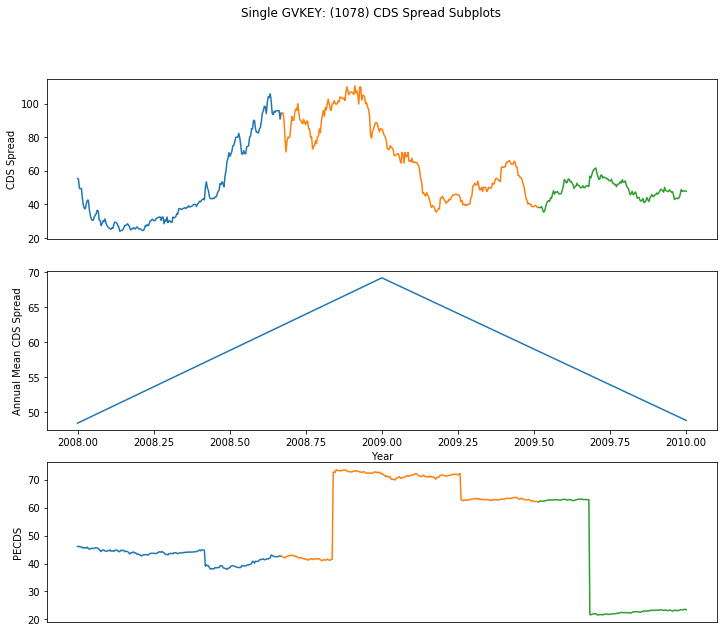

In [24]:
#infographic of GVKEY: 

#insert GVKEY, view evolution of the key's CDS series & annual mean changes
#also: 2184 // 1045 
gvkey_selection = 1078

gvkey_group_df = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]
print(" COMPANY == ", gvkey_group_df.company_name.iloc[0], '\n', "SECTOR ==  ", gvkey_group_df.sector.iloc[0])

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,10))
fig.suptitle('Single GVKEY: ({}) CDS Spread Subplots'.format(gvkey_selection))

gvkey_group_df.groupby(['year_index'])['market_cds_spread'].plot(ax=ax1)
ax1.set_ylabel('CDS Spread')
ax1.axes.get_xaxis().set_visible(False)


gvkey_group_df.groupby(['year_index']).mean()['market_cds_spread'].plot(ax=ax2);
ax2.set_ylabel('Annual Mean CDS Spread')
ax2.set_xlabel('Year')

gvkey_group_df.groupby(['year_index'])['pecds'].plot(ax=ax3)
ax3.set_ylabel('PECDS')
ax3.axes.get_xaxis().set_visible(False);

In [ ]:
# Fit the model
# (a switching mean is the default of the MarkovRegession model)
mod_fedfunds = sm.tsa.MarkovRegression(dta_fedfunds, k_regimes=2)
res_fedfunds = mod_fedfunds.fit()


In [6]:
#pick a sample GVKEY:
gvkey_1045 = sorted_alldata_df_final.loc[sorted_alldata_df_final.gvkey==1045]

In [8]:
#insert GVKEY
gvkey_selection = 1045
gvkey_frame = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]

#define variables
cds = gvkey_frame['market_cds_spread']
pecds = gvkey_frame['pecds']

#vix = gvkey_frame['cboe_vix']

#specify for CDS 
gvkey_frame_ms = pd.DataFrame(data=(cds))

gvkey_frame_ms_model = sm.tsa.MarkovRegression(gvkey_frame_ms, k_regimes=2)

res_gvkey_frame_ms_model = gvkey_frame_ms_model.fit()

print(res_gvkey_frame_ms_model.summary())

                        Markov Switching Model Results                        
Dep. Variable:      market_cds_spread   No. Observations:                  546
Model:               MarkovRegression   Log Likelihood               -3800.365
Date:                Mon, 21 Dec 2020   AIC                           7610.729
Time:                        16:57:26   BIC                           7632.242
Sample:                             0   HQIC                          7619.139
                                - 546                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1462.7267     15.101     96.860      0.000    1433.128    1492.325
                             Regime 1 parameters    

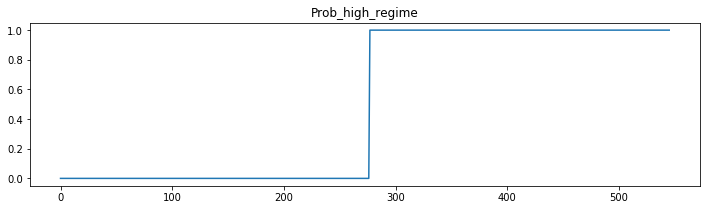

In [19]:
res_gvkey_frame_ms_model.smoothed_marginal_probabilities[1].plot(title='Pr(High Regime)',
                                                                figsize=(12,3));

In [20]:
#From the estimated transition matrix we can calculate the expected duration of a low regime versus a high regime.
print(res_gvkey_frame_ms_model.expected_durations)

[551.13730704 540.90648847]


In [ ]:
#switching intercept and lagged dependent variable

In [12]:

gvkey_selection = 1045
gvkey_frame = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]


cds = gvkey_frame['market_cds_spread']
pecds = gvkey_frame['pecds']

gvkey_frame_ms = pd.DataFrame(data=(cds, pecds)).T

#with switching intercept and lagged dependent variable
res_gvkey_frame_ms_model_2 = sm.tsa.MarkovRegression(gvkey_frame_ms['market_cds_spread'],
                                                     k_regimes=2, 
                                                     exog=gvkey_frame_ms['pecds'])

res_gvkey_frame_ms_model_2 = res_gvkey_frame_ms_model_2.fit()

print(res_gvkey_frame_ms_model_2.summary())

                        Markov Switching Model Results                        
Dep. Variable:      market_cds_spread   No. Observations:                  546
Model:               MarkovRegression   Log Likelihood               -3786.866
Date:                Mon, 21 Dec 2020   AIC                           7587.732
Time:                        17:00:47   BIC                           7617.851
Sample:                             0   HQIC                          7599.506
                                - 546                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1005.0053     88.245     11.389      0.000     832.048    1177.962
x1            15.4755      2.942      5.261      0.0

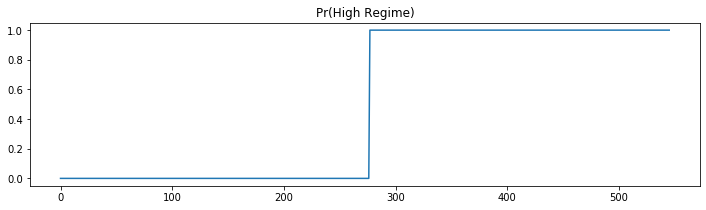

In [15]:
res_gvkey_frame_ms_model_2.smoothed_marginal_probabilities[1].plot(title='Pr(High Regime)',
                                                                figsize=(12,3));

In [14]:
#From the estimated transition matrix we can calculate the expected duration of a low regime versus a high regime.
print(res_gvkey_frame_ms_model_2.expected_durations)

[550.58287636 540.77126786]


# Switching Variances:


In [17]:
#insert GVKEY
gvkey_selection = 1045
gvkey_frame = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]

cds = gvkey_frame['market_cds_spread']
pecds = gvkey_frame['pecds']

gvkey_frame_ms = pd.DataFrame(data=(cds, pecds)).T

#with switching intercept and lagged dependent variable
res_gvkey_frame_ms_model_3 = sm.tsa.MarkovRegression(gvkey_frame_ms['market_cds_spread'],
                                                     k_regimes=2, 
                                                     exog=gvkey_frame_ms['pecds'],
                                                    switching_variance=True)

res_gvkey_frame_ms_model_3 = res_gvkey_frame_ms_model_3.fit()

print(res_gvkey_frame_ms_model_3.summary())

                        Markov Switching Model Results                        
Dep. Variable:      market_cds_spread   No. Observations:                  546
Model:               MarkovRegression   Log Likelihood                3869.843
Date:                Mon, 21 Dec 2020   AIC                          -7723.686
Time:                        17:03:04   BIC                          -7689.265
Sample:                             0   HQIC                         -7710.231
                                - 546                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1005.0056   1.54e-28   6.52e+30      0.000    1005.006    1005.006
x1            15.4755   6.02e-29   2.57e+29      0.0

C:\Users\JasonSpano\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\JasonSpano\anaconda3\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\JasonSpano\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\JasonSpano\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\JasonSpano\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


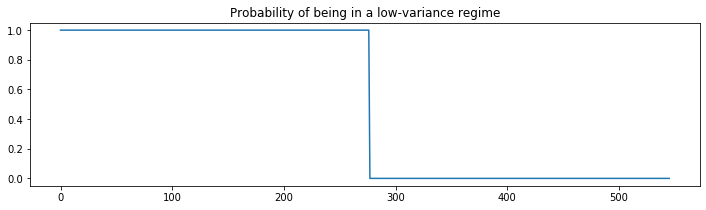

In [18]:
res_gvkey_frame_ms_model_3.smoothed_marginal_probabilities[0].plot(
title='Probability of being in a low-variance regime', 
figsize=(12, 3));

## Explanation: 

* the x-axis, 0-546 (nobs) is acting like the time-series (no index specified)
* Thus, this coincides with the break-points established by ZA

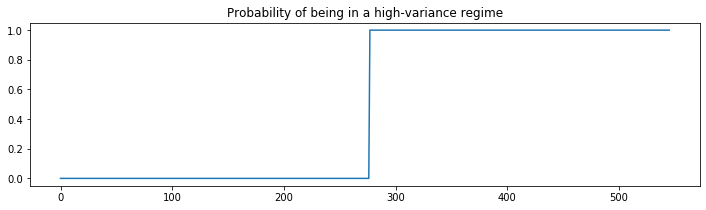

In [20]:
res_gvkey_frame_ms_model_3.smoothed_marginal_probabilities[1].plot(
title='Probability of being in a high-variance regime', 
figsize=(12, 3));

### Experiment with different GVKEY: 

In [ ]:
#re-try with GVKEY: 1078

#slightly more normal spread variance:

In [25]:
#insert GVKEY
gvkey_selection = 1078
gvkey_frame = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]

cds = gvkey_frame['market_cds_spread']
pecds = gvkey_frame['pecds']

gvkey_frame_ms = pd.DataFrame(data=(cds, pecds)).T

#with switching intercept and lagged dependent variable
res_gvkey_frame_ms_model_3 = sm.tsa.MarkovRegression(gvkey_frame_ms['market_cds_spread'],
                                                     k_regimes=2, 
                                                     exog=gvkey_frame_ms['pecds'],
                                                    switching_variance=True)

res_gvkey_frame_ms_model_3 = res_gvkey_frame_ms_model_3.fit()

print(res_gvkey_frame_ms_model_3.summary())

C:\Users\JasonSpano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:      market_cds_spread   No. Observations:                  620
Model:               MarkovRegression   Log Likelihood               -2369.390
Date:                Mon, 21 Dec 2020   AIC                           4754.780
Time:                        17:09:06   BIC                           4790.217
Sample:                             0   HQIC                          4768.555
                                - 620                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8945      2.114      2.315      0.021       0.751       9.038
x1             0.6281      0.038     16.546      0.0

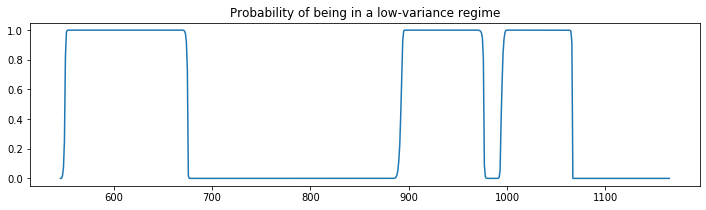

In [26]:
res_gvkey_frame_ms_model_3.smoothed_marginal_probabilities[0].plot(
title='Probability of being in a low-variance regime', 
figsize=(12, 3));

In [ ]:
#the "const" term in each regime parameters == the mean (CDS?) in that regime
#e.g. 4.89 in the first regime, and 41.8 in the high regime (2nd)

In [28]:
see(res_gvkey_frame_ms_model_3)

    <                              <=                             ==                             !=
    >                              >=                             dir()                          hash()
    help()                         repr()                         str()                          .aic
    .bic                           .bse                           .conditional_loglikelihoods    .conf_int()
    .cov_kwds                      .cov_params()                  .cov_params_approx             .cov_params_default
    .cov_params_opg                .cov_params_robust             .cov_type                      .data
    .expected_durations            .f_test()                      .filter_results
    .filtered_joint_probabilities                                 .filtered_marginal_probabilities
    .fittedvalues                  .forecast()                    .hqic                          .initial_probabilities
    .initialize()                  .joint_likelihoods           

In [30]:
#how many observations each regime is expected to last, low == 82, high == 129
res_gvkey_frame_ms_model_3.expected_durations

array([ 82.88168621, 129.27509933])

In [32]:
res_gvkey_frame_ms_model_3.regime_transition

array([[[0.98793461],
        [0.00773544]],

       [[0.01206539],
        [0.99226456]]])

In [49]:
res_gvkey_frame_ms_model_3.pvalues

p[0->0]      0.000000e+00
p[1->0]      9.130032e-02
const[0]     2.059289e-02
const[1]     1.259554e-73
x1[0]        1.716605e-61
x1[1]        3.172345e-42
sigma2[0]    2.720161e-26
sigma2[1]    3.364852e-37
dtype: float64

In [47]:
res_gvkey_frame_ms_model_3.initial_probabilities

array([0.39066243, 0.60933757])

In [43]:
res_gvkey_frame_ms_model_3.cov_params()

,p[0->0],p[1->0],const[0],const[1],x1[0],x1[1],sigma2[0],sigma2[1]
p[0->0],0.000040,-2.143943e-06,-0.000061,-0.000046,1.436670e-06,1.759997e-06,0.000203,-0.000546
p[1->0],-0.000002,2.098592e-05,-0.000030,-0.000022,7.056969e-07,8.534383e-07,0.000104,-0.000254
const[0],-0.000061,-2.964047e-05,4.468622,0.315806,-7.878001e-02,-9.784904e-03,-0.838330,1.941767
const[1],-0.000046,-2.228305e-05,0.315806,5.302299,-6.654247e-03,-1.029990e-01,-0.597866,1.471927
x1[0],0.000001,7.056969e-07,-0.078780,-0.006654,1.441243e-03,2.129913e-04,0.019513,-0.045899
x1[1],0.000002,8.534383e-07,-0.009785,-0.102999,2.129913e-04,2.377525e-03,0.022268,-0.057051
sigma2[0],0.000203,1.037643e-04,-0.838330,-0.597866,1.951349e-02,2.226815e-02,13.906166,-6.261839
sigma2[1],-0.000546,-2.541291e-04,1.941767,1.471927,-4.589858e-02,-5.705103e-02,-6.261839,430.405236


In [42]:
res_gvkey_frame_ms_model_3.conf_int()

,0,1
p[0->0],0.975553,1.000316
p[1->0],-0.001243,0.016714
const[0],0.751289,9.037670
const[1],37.282776,46.309085
x1[0],0.553733,0.702548
x1[1],0.568397,0.759532
sigma2[0],32.251316,46.869109
sigma2[1],223.728815,305.052464


In [36]:
see(res_gvkey_frame_ms_model_3.params)

    .*               []               in               +                +=               -                -=
    *                *=               @                /                /=               //               //=
    %                %=               **               **=              &                &=               ^
    ^=               |                |=               +obj             -obj             ~                <
    <=               ==               !=               >                >=               abs()            bool()
    dir()            divmod()         float()          hash()           help()           int()            iter()
    len()            repr()           round()          str()            .T               .abs()           .add()
    .add_prefix()    .add_suffix()    .agg()           .aggregate()     .align()         .all()           .any()
    .append()        .apply()         .argmax()        .argmin()        .argsort()       .array           .asfreq

In [37]:
res_gvkey_frame_ms_model_3.params.kurtosis()

7.076847948964414

In [35]:
res_gvkey_frame_ms_model_3.params

p[0->0]        0.987935
p[1->0]        0.007735
const[0]       4.894480
const[1]      41.795931
x1[0]          0.628140
x1[1]          0.663964
sigma2[0]     39.560212
sigma2[1]    264.390639
dtype: float64

In [34]:
res_gvkey_frame_ms_model_3.filtered_marginal_probabilities

,0,1
546,7.704655e-03,0.992295
547,2.606005e-04,0.999739
548,2.499842e-03,0.997500
549,3.132653e-03,0.996867
550,3.481786e-03,0.996518
...,...,...
1161,1.049696e-06,0.999999
1162,8.316824e-07,0.999999
1163,1.039101e-06,0.999999
1164,9.726994e-07,0.999999


In [25]:
#further regimes = taylor rule etc.

#taylor rule with 3 regimes:

